# Overview of Co-simulation 
This file is the transmission simulation federate file. It controls the simulation of the transmission system. The code includes the dynamic simulation of transmission and the interface of data exchange with other simulators such as the distribution simulator.

## Introduction
- Cohorent execution of multiple distinct simulation objects to function together seamlessly.
- Co-simulation is employed when a single simulator is inadequate for addressing the relevant questions.

## Terminology
- Simulator - A simulator is the executable that is able to perform some analysis function, often but not always, by solving specific problems to generate a time series of values [1].
- Federate - An individual simulator that is used for any computation and information exchange with other federates
- Core - An object that manages the interaction among the federates.
- Broker - An object coordinating multiple cores or brokers. It is reponsible for passing signals between federates.
- Federation - The set of all federates executing together in a single co-simulation

## Stages of Co-simulation 
### Creation
Federate creation involves registering an executable as a component of a HELICS federation (co-simulation) while            setting up the simulation time synchronization process and data exchange interfaces. This process establishes              the HELICS "creation state."[1]
### Initialization
The initialization mode allows a federation to prepare for advancing through simulation time. During this phase, federates may engage in iterative data exchange to achieve a collectively consistent state, load historical or state data to initialize their internal models, or simply wait for other federates to complete these processes. Additionally, federates can use initialization mode to publish values that will be accessible to all federates within this phase or, for non-iterative cases, at simulation time 0 in the main simulation. A federate can skip this stage if it does not require visibility into other federates operating in initialization mode
### Execution 
After a federate is created, with all subscriptions, publications, and endpoints registered, and the federation's initial state properly configured, federates transition into the main co-simulation phase by calling **helicsEnterExecutingMode()**. Upon entering this mode, the HELICS simulation time is initialized to zero, and any values published or messages sent during the initialization phase become available to the federation. The typical structure of data exchange in HELICS requires all federates to enter execution mode before any of them begin the co-simulation process.
### Finalization
Once a federate has completed its role in the co-simulation and simulated the required time, it must properly disconnect from the federation. This is done using the **destroy_federate(fed)** API, which notifies the core and brokers that the federate is exiting the co-simulation. Additionally, this step ensures the proper closure of the HELICS library, freeing up resources and finalizing the simulation process.


## HELICS Capabilities
- Scalable: Supports from 2 up to 10,000,000+ federates, enabling simulations of varying complexity.
- Cross-Platform: Runs on Linux, Windows & macOS.
- Modular: Flexible architecture allows seamless integration of diverse tools.
- Open Source: Licensed under a BSD-style framework.
- Diverse Simulation Types:
- Discrete Event – Event-driven simulations for system behavior analysis.
  - QSTS (Quasi-Static Time Series) – Time-series simulations for power systems.
  - Dynamics – Captures system behavior over continuous time.
  - Co-Iteration Enabled: Supports "tight coupling" for enhanced synchronization and iterative feedback between simulators.

## Transmission and Distribution (T&D) Co-simulation
The co-simulation framework employs HELICS to synchronize Transmission (T) and Distribution (D) simulators, enabling time-step-based information exchange without intra-time step iterations. As shown in Fig. 1, the information exchange occurs sequentially, ensuring simulation robustness through structured data transfer. The dashed arrow pointing to the right represents the simulation time, while the dashed rectangles indicate the changing states of the T&D simulators over time [2].

![Fig. 1. Simulation Flow in terms of Simulation time [2]](simulation_flow.jpeg)

**Fig. 1. Simulation Flow in terms of Simulation time [2]**

## Integration with HELICS
The HELICS co-simulation platform supports simulators operating across multiple time domains, with simulation time synchronization managed implicitly by a broker[2]. As shown in Fig. 2 the innformation exchange is facilitated through either subscriptions/publications or endpoint communications. The HELICS command-line interface (helics-cli) can be used within a terminal script to initiate co-simulations, allowing all simulators to run simultaneously. Additionally, variations in communication latency and packet loss can be modeled at the endpoints, enabling the simulation of cyber-physical interactions. In this example, the co-simulation platform integrates HELICS, ANDES, and OpenDSS.

![Fig. 2. Co-simulation integration in HELICS [2]](helics_integration.jpg)

**Fig. 2. Co-simulation integration in HELICS [2]**

# Transmission Federate
This is a transmission federate that includes the simulation of the transmission system. For this co-simulation, the transmission federate publishes the voltage angle and magnitude data, which the distribution federate subscribes to. 
## Steps used to configure a transmission federate
1. Broker initialization and creation to connect with distribution federate.
2. Creating a federate with information.
3. Register publication and subscription items
4. Load system data for transmission for exectution
5. Fix simulation step and time for co-simulaiton 
6. Run co-simulation

### Simulator
ANDES has been used as a transmission simulator for this cosimulation [3]. IT is an open-source Python library designed for power system modeling, computation, analysis, and control, acting as the core simulation engine for the CURENT Large-Scale Testbed (LTB). It enables power flow calculations, transient stability simulations, and small-signal stability analysis for transmission systems.

### Methodology
Bus 4 of the IEEE-14 bus transmission system is connected to the IEEE-34 bus distribution system. The IEEE-34 bus distribution federate publishes the values of active power (P) and reactive power (Q). The transmission federate subscribes to P and Q from the IEEE-34 bus distribution system.The simulation step used is 1 second. After each simulation step, the voltage magnitude and angle of bus 4 are published. The load of the IEEE-34 bus system undergoes random load variations with a standard deviation of 2.5%, and this variation should be reflected at bus 4 of the transmission system during co-simulation.

#### To run the co-simulation, we must run Transmission_Federate.ipynb & Distrubtion_Federate.ipynb together (run all cells at once).


Import helics and andes.
- If helics has not been installed, run !pip install helics inside a cell.
- If andes has not been installed, run !pip install andes inside a cell.


In [1]:
import os
import sys
import time
import numpy as np
import helics as h
import pandas as pd
import matplotlib.pyplot as plt
import andes
import scipy.stats
import scipy.io as readmat
import os

## Initialization to start a broker 

Here, we initialize the main broker for this federate with two connected federates. The number '2' represents the number of federates being connected.

In [2]:
helicsversion = h.helicsGetVersion()
print("Helics version = {}".format(helicsversion))
brokerinitstring = "-f 2 --name=mainbroker" 

Helics version = 3.5.2 (2024-04-08)


## Create a broker
HELICS utilizes various underlying communication technologies to facilitate coordination among co-simulation components. Some of these technologies, like ZeroMQ (zmq), are designed to be broadly applicable. Here zmq core is used while creating a broker.

In [3]:

broker = h.helicsCreateBroker("zmq", "", brokerinitstring)
isconnected = h.helicsBrokerIsConnected(broker)
if isconnected == 1:
    print("Broker created and connected")

Broker created and connected


## Create a Transmission Federate info object

First, create a Federate Info object to define the federate's properties and set the core type using fedstring. Note that the minimum time step in HELICS is 1 nanosecond. A time delta of 0.01 represents the smallest interval at which the federate can receive updates if a publication occurs at 0 seconds. However, since publications take place every second in this co-simulation, the federate will receive updates at one-second intervals.

In [4]:
federate_name="Transmission"
fedinfo = h.helicsCreateFederateInfo()
fedinitstring = "--broker=mainbroker --federates=1" 
h.helicsFederateInfoSetCoreName(fedinfo, f"{federate_name}") 
h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq") 
h.helicsFederateInfoSetCoreInitString(fedinfo, fedinitstring) 
h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)

## Create a value federate

Based on the type of data exchange, the federate is created. Here, we create a value federate, as the federates simulate the physics of the system. Value federates provide information about the physical values of the system with associated units. Since the signals for publication and subscription are power and voltage, both federates in this co-simulation are value federates.

In [5]:
fed = h.helicsCreateValueFederate(f"{federate_name}", fedinfo)
print(f"{federate_name}: Value federate created", flush=True)

Transmission: Value federate created


Set the publication and subscription items in a dictionary and register the publications and subscriptions.

In [6]:
PUBLICATIONS = {}
SUBSCRIPTIONS = {}
publications={
    "transmission_voltage/bus_4": {
      "pub_interval": 1,
      "type": "complex",
      "global": True,
      "unit": "pu",
      "vbase": 69,
      "vbase_unit": "kv",
      "topic": "TransmissionSim/Voltage_4",
      "value": "Voltage",
      "element_name": "4",
      "element_type": "Bus"
    }
}
subscriptions={
    "34Bus": {
      "type": "complex",
      "required": True,
      "sub_interval": 1,
      "topic": "34Bus/Totalpower",
      "value": "Powers",
      "element_name": "4",
      "bus_PQ_index": 2
    }
  }
for k, v in publications.items():
    pub = h.helicsFederateRegisterGlobalTypePublication(fed, v['topic'], v['type'], "") # register to helics
    PUBLICATIONS[k] = pub # store the HELICS object

for k, v in subscriptions.items():
    sub = h.helicsFederateRegisterSubscription(fed, v['topic'], "")
    SUBSCRIPTIONS[k] = sub  # store the HELICS object

## Enter Execution

Here, we enter the execution mode. When we do not run the connected federates synchronously, the program might get stuck at this step. Restart the kernel in such a scenario and run them together. Therefore, we must run all the cells in parallel for all the federates. Each federate needs to enter execution mode before beginning to exchange information.

In [7]:
h.helicsFederateEnterExecutingMode(fed)
print(f"{federate_name}: Entering execution mode", flush=True)

Transmission: Entering execution mode


## Load case and run powerflow

For the simulation of the transmission system, we use ANDES. ANDES uses a standard file format in xlsx. To set up the dynamic time-domain simulation, we first run the steady-state power flow.

In [8]:
tr_path=os.getcwd() 
file_name = 'ieee14_full.xlsx'
path_to_transmission_xlsx = os.path.join(tr_path, "network_model",file_name)
andes.config_logger(stream_level=20)
ieee14 = andes.get_case(path_to_transmission_xlsx)
ss = andes.load(ieee14, setup=False, no_output=True)
ss.setup()
ss.PQ.config.p2p = 1 
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0
ss.PFlow.run()
os.chdir(tr_path)

Working directory: "C:\Users\pb1052\Desktop\powercybertraining.github.io\pct\modules\06"
> Loaded config from file "C:\Users\pb1052\.andes\andes.rc"
> Loaded generated Python code in "C:\Users\pb1052\.andes\pycode".
Parsing input file "C:\Users\pb1052\Desktop\powercybertraining.github.io\pct\modules\06\network_model\ieee14_full.xlsx"...
Input file parsed in 1.3575 seconds.
System internal structure set up in 0.1579 seconds.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0300 seconds.
0: |F(x)| = 0.5605182134
1: |F(x)| = 0.006202200332
2: |F(x)| = 5.819382825e-06
3: |F(x)| = 6.957087684e-12
Converged in 4 iterations in 0.0318 seconds.


## Initilization for TDS (time -domain-simulation)

In [9]:

ss.TDS.init()
ss.TDS.criteria = 0

Initialization for dynamics completed in 0.2207 seconds.
Initialization was successful.


## Main Loop for Co-simulation

This is the main loop for co-simulation. In this loop, the TDS is executed every second, and the voltage magnitude and angles for bus 4 are published. Similarly, the subscriptions for active and reactive power also occur in the main loop. The loop terminates once the total requested simulation time is reached. Once terminated, the federate must be closed. We only use the active power from the distribution federate, although we receive both active and reactive power.

In [10]:
total_time=15 
simulation_step_time=1
current_time=0
shed_buses = ss.PQ.bus.v
pq_shed_idx = ss.PQ.find_idx(keys='bus', values=shed_buses)
P_active=[]
Q_reactive=[]
time_list=[]
for request_time in np.arange(0, total_time, simulation_step_time):
    while current_time < request_time:
        current_time = h.helicsFederateRequestTime(fed, request_time)
    print("=============================")
    print(f"request_time={request_time}")
    print(f"current_time={current_time}")
    for key, sub in SUBSCRIPTIONS.items():
        if subscriptions[key]['value']=='Powers':
            if current_time % subscriptions[key]['sub_interval']<=1e-6:
                val = h.helicsInputGetComplex(sub) # val is P, Q
                bus_name = subscriptions[key]['element_name']
                bus_PQ_index = int(subscriptions[key]['bus_PQ_index'])
                P, Q = val.real,val.imag
                print("Received active power from {} at time {}: {} kw".format(key, current_time, P))
                print("Received reactive power (not use) from {} at time {}: {} kvar".format(key, current_time, Q))
                # convert to pu
                P = P/1e5
                Q = Q/1e5

            if current_time == 0:
                print("manually set up first step load bus P and Q")
                P = ss.PQ.p0.v[int(bus_PQ_index)]
                Q = 0
            P_active.append(P)
            Q_reactive.append(Q)
            time_list.append(current_time)
            ss.PQ.set(src='Ppf', idx=pq_shed_idx[int(bus_PQ_index)], attr='v', value=P) # set load as P
            
    ss.TDS.config.tf = current_time + simulation_step_time
    ss.TDS.run()
    
    #Get the PUBLICATION OUT
    for key, pub in PUBLICATIONS.items():
        if publications[key]['value']=='Voltage':
            bus_name = publications[key]['element_name']
            element_type = publications[key]['element_type']

            val1 = ss.Bus.v.v[int(bus_name)-1]
            val2 = ss.Bus.a.v[int(bus_name)-1]
            if current_time % publications[key]['pub_interval']<=1e-6:
                print("Sent voltage mag at time {}: {} pu from {} {}".format(current_time, val1, element_type, bus_name))
                print("Sent voltage ang at time {}: {} rad from {} {}".format(current_time, val2, element_type, bus_name))
               
                h.helicsPublicationPublishComplex(pub, val1, val2)
    if ss.exit_code != 0:
        raise ValueError(current_time)
        
h.helicsFederateDestroy(fed)
print('Federate finalized')


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=10 ms. Shrink if not converged.


request_time=0
current_time=0
Received active power from 34Bus at time 0: -1e+49 kw
Received reactive power (not use) from 34Bus at time 0: 0.0 kvar
manually set up first step load bus P and Q


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=1.00 sec completed in 0.7579 seconds.


Sent voltage mag at time 0: 1.0114034500520985 pu from Bus 4
Sent voltage ang at time 0: -0.07696511657375282 rad from Bus 4
request_time=1
current_time=1.0
Received active power from 34Bus at time 1.0: 47801.63821906519 kw
Received reactive power (not use) from 34Bus at time 1.0: 7409.155582643104 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=2.00 sec completed in 1.1523 seconds.


Sent voltage mag at time 1.0: 1.0114017897852616 pu from Bus 4
Sent voltage ang at time 1.0: -0.07701999689473964 rad from Bus 4
request_time=2
current_time=2.0
Received active power from 34Bus at time 2.0: 44555.32097323309 kw
Received reactive power (not use) from 34Bus at time 2.0: 4131.780286959751 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=3.00 sec completed in 1.5256 seconds.


Sent voltage mag at time 2.0: 1.0150471521545343 pu from Bus 4
Sent voltage ang at time 2.0: 0.03771978943092093 rad from Bus 4
request_time=3
current_time=3.0
Received active power from 34Bus at time 3.0: 48936.626802411876 kw
Received reactive power (not use) from 34Bus at time 3.0: 8771.692939510162 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=4.00 sec completed in 2.2365 seconds.


Sent voltage mag at time 3.0: 1.0102428412284292 pu from Bus 4
Sent voltage ang at time 3.0: 0.11948258019445407 rad from Bus 4
request_time=4
current_time=4.0
Received active power from 34Bus at time 4.0: 48665.00424393096 kw
Received reactive power (not use) from 34Bus at time 4.0: 8410.171636300856 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=5.00 sec completed in 1.3206 seconds.


Sent voltage mag at time 4.0: 1.0093102038445478 pu from Bus 4
Sent voltage ang at time 4.0: 0.08130224185712621 rad from Bus 4
request_time=5
current_time=5.0
Received active power from 34Bus at time 5.0: 47629.57937222962 kw
Received reactive power (not use) from 34Bus at time 5.0: 6634.29313883343 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=6.00 sec completed in 1.2844 seconds.


Sent voltage mag at time 5.0: 1.0109718580124958 pu from Bus 4
Sent voltage ang at time 5.0: 0.03995230968111265 rad from Bus 4
request_time=6
current_time=6.0
Received active power from 34Bus at time 6.0: 48293.16388524481 kw
Received reactive power (not use) from 34Bus at time 6.0: 8039.064697773521 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=7.00 sec completed in 1.4057 seconds.


Sent voltage mag at time 6.0: 1.0109823766112858 pu from Bus 4
Sent voltage ang at time 6.0: 0.009963599003813623 rad from Bus 4
request_time=7
current_time=7.0
Received active power from 34Bus at time 7.0: 46564.21698968369 kw
Received reactive power (not use) from 34Bus at time 7.0: 5827.129031845077 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=8.00 sec completed in 1.3704 seconds.


Sent voltage mag at time 7.0: 1.0129721486187104 pu from Bus 4
Sent voltage ang at time 7.0: 0.03572267205559312 rad from Bus 4
request_time=8
current_time=8.0
Received active power from 34Bus at time 8.0: 48751.534020578525 kw
Received reactive power (not use) from 34Bus at time 8.0: 8571.596419497073 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=9.00 sec completed in 1.7288 seconds.


Sent voltage mag at time 8.0: 1.010694513796309 pu from Bus 4
Sent voltage ang at time 8.0: 0.04614371938109189 rad from Bus 4
request_time=9
current_time=9.0
Received active power from 34Bus at time 9.0: 46699.97595885882 kw
Received reactive power (not use) from 34Bus at time 9.0: 5828.557753324128 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=10.00 sec completed in 1.7383 seconds.


Sent voltage mag at time 9.0: 1.0123827870294335 pu from Bus 4
Sent voltage ang at time 9.0: 0.06708615369974795 rad from Bus 4
request_time=10
current_time=10.0
Received active power from 34Bus at time 10.0: 49850.86564904258 kw
Received reactive power (not use) from 34Bus at time 10.0: 9818.809130524067 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=11.00 sec completed in 1.7847 seconds.


Sent voltage mag at time 10.0: 1.0092901285406106 pu from Bus 4
Sent voltage ang at time 10.0: 0.027644899680144122 rad from Bus 4
request_time=11
current_time=11.0
Received active power from 34Bus at time 11.0: 47790.67606338326 kw
Received reactive power (not use) from 34Bus at time 11.0: 7319.615641070466 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=12.00 sec completed in 1.7329 seconds.


Sent voltage mag at time 11.0: 1.0112549300302598 pu from Bus 4
Sent voltage ang at time 11.0: -0.027862560702964737 rad from Bus 4
request_time=12
current_time=12.0
Received active power from 34Bus at time 12.0: 48687.91038993947 kw
Received reactive power (not use) from 34Bus at time 12.0: 8335.418469261398 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=13.00 sec completed in 1.7492 seconds.


Sent voltage mag at time 12.0: 1.0110126068999175 pu from Bus 4
Sent voltage ang at time 12.0: -0.06834605251916671 rad from Bus 4
request_time=13
current_time=13.0
Received active power from 34Bus at time 13.0: 47564.54169136476 kw
Received reactive power (not use) from 34Bus at time 13.0: 7169.053648209873 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=14.00 sec completed in 1.4800 seconds.


Sent voltage mag at time 13.0: 1.0121787071863926 pu from Bus 4
Sent voltage ang at time 13.0: -0.0782936099467949 rad from Bus 4
request_time=14
current_time=14.0
Received active power from 34Bus at time 14.0: 46406.50206760576 kw
Received reactive power (not use) from 34Bus at time 14.0: 5405.051761514724 kvar


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation to t=15.00 sec completed in 1.5499 seconds.


Sent voltage mag at time 14.0: 1.0135693277385962 pu from Bus 4
Sent voltage ang at time 14.0: -0.012455029343775645 rad from Bus 4
Federate finalized


Here, we plot the received active and reactive power from the distribution federate.

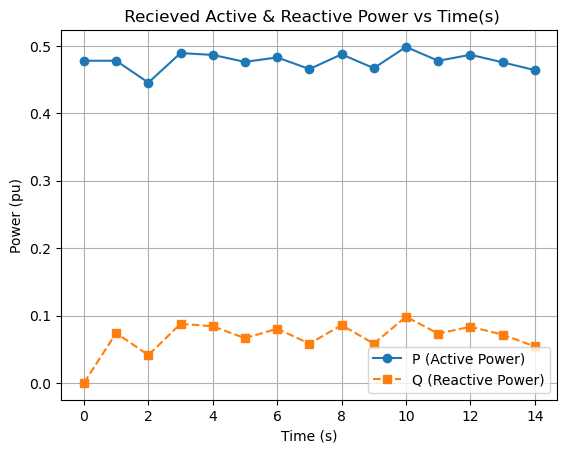

In [11]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.figure(figsize=(6.4, 4.8))
plt.plot(time_list, P_active, label="P (Active Power)", marker='o', linestyle='-')
plt.plot(time_list, Q_reactive, label="Q (Reactive Power)", marker='s', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Power (pu)")
plt.title(" Recieved Active & Reactive Power vs Time(s)")
plt.legend()
plt.grid(True)
plt.show()


Here, we plot frequency at bus 4 (load bus) of transmission system.

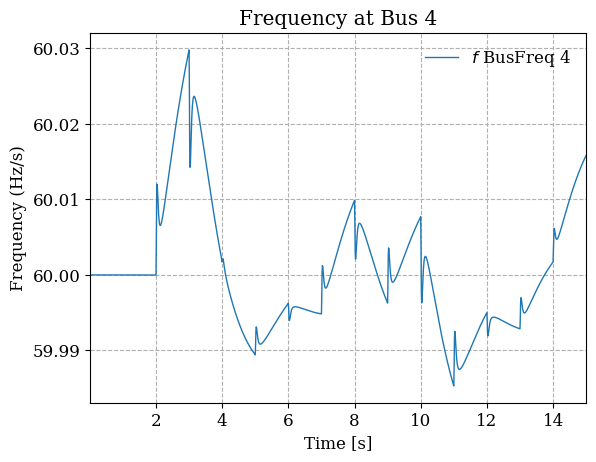

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Frequency at Bus 4'}, xlabel='Time [s]', ylabel='Frequency (Hz/s)'>)

In [12]:
ss.TDS.load_plotter()
ss.TDS.plt.plot(ss.BusFreq.f,ylabel='Frequency (Hz/s)',a=(3,),ytimes=60,title='Frequency at Bus 4',grid=True)

# Result Analysis
At every 1 second, the transmission federate receives P and Q values for the load at bus 4 from the distribution federate. Since there is load variation in the distribution feeder at each second, it can be observed in the P & Q values received by the transmission federate. After receiving the values of P & Q, the transmission federate runs the simulation for the next time steps and sends the voltage magnitude and angle to the distribution federate through publication.

# References

1. T. D. Hardy, B. Palmintier, P. L. Top, D. Krishnamurthy, and J. C. Fuller, “Helics: A co-simulation framework for scalable multi-domain modeling and analysis,” IEEE Access, vol. 12, pp.24 325–24 347, 2024.
2. W. Wang, X. Fang, H. Cui, F. Li, Y. Liu, and T. J. Overbye,“Transmission-and-distribution dynamic co-simulation framework for distributed energy resource frequency response,” IEEE Transactions on Smart Grid, vol. 13, no. 1, pp. 482–495, 2021.
3. H. Cui, F. Li, and K. Tomsovic, “Hybrid symbolic-numeric framework for power system modeling and analysis,” IEEE Trans. Power Syst., vol. 36, no. 2, pp. 1373–1384, 2021.